In [1]:
# import all required libreries

import pandas as pd
import numpy as np
import random
from scipy.stats import bernoulli
from scipy.stats import norm
import math
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("Data/sampled_counterparts.csv")
df = df.iloc[[38-2, 260-2, 7816-2]]

F = pd.read_csv("Data/F_for_sampled_counterparts.csv")
sectors = [1, 2]
F_list = [[F.iloc[df.index.values[j]][i-1] for i in sectors] for j in range(len(df))]

print(F_list)
df

[[0.1580707722, 0.057751624756012], [0.2555327991, 0.157171844120119], [0.558427409615099, 0.04397951004988]]


,cluster,pd,lgd dwt,ead,num ctp,sett,is,acca,cod type,cod stato,lgd pag
36,005118_618,0.256511,0.223071,82514.537908,83292,5,0.300000,0.000083,0,0,0.187699
258,002116_18,0.071557,0.194311,282063.242107,888,2,0.300000,0.019318,0,0,0.157672
7814,010817_14,0.102194,0.350912,141607.211932,4,10,0.657714,0.010912,0,0,0.334555


In [53]:
#set problem parameters

p_zeros = [el['pd'] for _, el in df.iterrows()]
rhos = [el['is']**2 for _, el in df.iterrows()]
lgd = [el['lgd dwt']*el['ead'] for _, el in df.iterrows()]

#alphas_list = [[0.35,0.2],[0.1,0.25]]

K = len(p_zeros)
alpha = 0.05
num_simulations = 50000

print(f'F: {F_list}\nRhos: {np.sqrt(rhos)}\nLgds: {lgd}\np_zeros: {p_zeros}')

F: [[0.1580707722, 0.057751624756012], [0.2555327991, 0.157171844120119], [0.558427409615099, 0.04397951004988]]
Rhos: [0.3        0.3        0.65771356]
Lgds: [18406.56224845756, 54807.94141703075, 49691.709801894605]
p_zeros: [0.2565108504, 0.0715568886, 0.1021936371]


Calculate $P D_{C} \mid Z=\Phi\left(\frac{\Phi^{-1}\left(P D_{c}\right)-r_{c, s} \sum_{k=1}^{S} \alpha_{s, k} Z_{k}}{\sqrt{1-r_{c, s}^{2}}}\right)$

In [10]:
# function to sample bernoulli variables
def calculate_p(z, p_zeros, rhos):
    
    p = np.zeros((num_simulations, np.size(p_zeros)))

    for i in range(num_simulations):
        index = i * len(sectors)
        for k in range(0, K):
            p[i,k] = norm.cdf(
                (
                norm.ppf(p_zeros[k]) - np.sum([F*sim for F, sim in zip(F_list[k], z[index:index+len(sectors)])])
                ) / np.sqrt(1-rhos[k])
            ) 
    
    return p

In [11]:
# function to evaluate losses per each scenario
def calculate_loss_per_scenario(p, lgd):

    losses = np.zeros(p.shape[0])
    
    for i in range(0, p.shape[0]):
        for j in range(0, np.size(lgd)):
            losses[i] = losses[i] + lgd[j] * bernoulli.rvs(p[i, j])
    
    return losses

# function to calculate var
def calculate_var(losses, alpha):
    
    vect = losses
    vect = np.sort(vect)

    index = math.trunc((1-alpha) * np. size (vect))

    return vect[index]

In [12]:
# function to estimate empirical PDF and CDF of losses

def calculate_pdf_cdf(array):
    values = np.sort(np.unique(array))
    temp = np.sort(array)
    pdf = np.zeros(np.size(values))

    index = 0
    for i in range(0, np.size(array)):
        if temp[i]==values[index]:
            pdf[index] += 1
        else:
            index += 1
            pdf[index] += 1

    return pdf / np.size(array), np.cumsum(pdf) / np.size(array) 

In [25]:
# main of the code

#np.random.seed(30)
z = np.random.standard_normal(num_simulations*len(sectors))
p = calculate_p(z, p_zeros, rhos)
losses = calculate_loss_per_scenario(p, lgd)
expected_loss = sum(losses)/num_simulations
var = calculate_var(losses, alpha)

pdf, cdf = calculate_pdf_cdf(losses)

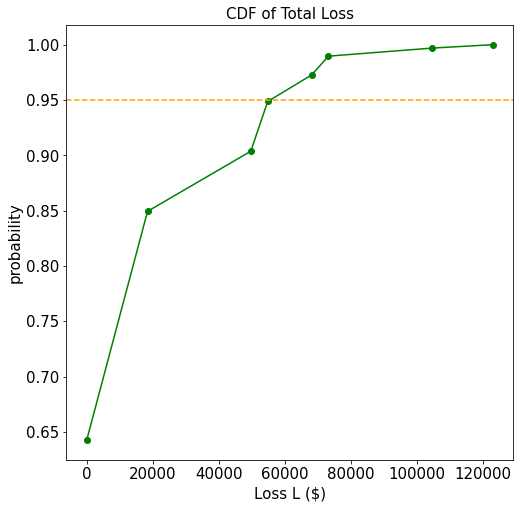

expected loss =  12989.391499054498
var =  68098.27205035217


In [51]:
# plot loss PDF, expected loss, var, and evar
plt.plot(np.sort(np.unique(losses)), cdf, 'o-g')#, align = "center", width = 90)
#plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]") 
plt.axhline(0.95, color="orange", linestyle="--")#, label="VaR(L)")
 
# plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability", size=15)
plt.title ("CDF of Total Loss", size=15)
plt.xticks(size=15) # plt.xticks(np.sort([int(n) for n in np.unique(losses)]), np.sort([int(n) for n in np.unique(losses)]), size=13)
plt.yticks(size=15)
plt.rcParams["figure.figsize"] = (8, 8)
plt.show()

print("expected loss = ", expected_loss)
print("var = ", var)